# FNN for MNIST Generation
### By: Jeremy Rico
### UNIQUIFY

This program uses a fully-connected neural network to generate handwritten
digits based on the MNIST dataset. 

### Import libraries

In [162]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras import Model

### Load Data



In [163]:
# Load dataset
mnist = tf.keras.datasets.mnist

# Split into train and test 
(y_train, x_train_old), (y_test, x_test_old) = mnist.load_data()

# Convert single digit label to one-hot vectors
x_train = np.zeros([x_train_old.shape[0], 10])
for i in range(len(x_train_old)):
    temp = np.zeros(10)
    temp[x_train_old[i]] = 1
    x_train[i] = temp

x_test = np.zeros([x_test_old.shape[0], 10])
for i in range(len(x_test_old)):
    temp = np.zeros(10)
    temp[x_test_old[i]] = 1
    x_test[i] = temp

# Reshape y
y_train = np.reshape(y_train, (y_train.shape[0], 784))
y_test = np.reshape(y_test, (y_test.shape[0], 784))

# Regularize label data
y_train, y_test = y_train.astype("float32") / 255.0, y_test.astype("float32") / 255.0

print("Data shapes: ")
print("X_train:", x_train.shape)
print("Y_train:", y_train.shape)
print("X_test: ", x_test.shape)
print("Y_test: ", y_test.shape)


Data shapes: 
X_train: (60000, 10)
Y_train: (60000, 784)
X_test:  (10000, 10)
Y_test:  (10000, 784)


### Shuffle and split data

In [164]:
# Shuffle and split the data into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

### Class definition

In [165]:
# Creation of sequential model
class MyModel(Model):

  # initializer
  def __init__(self):
    super(MyModel, self).__init__()
    self.d = Dense(10)
    self.d0 = Dense(128, activation='relu')
    self.d1 = Dense(265, activation='relu')
    #self.drop = Dropout(0.10)
    self.d2 = Dense(784)

  def call(self, x):
    #x = self.f1(x)
    x = self.d(x)
    x = self.d0(x)
    x = self.d1(x)
    #x = self.drop(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

### Define metrics

In [166]:
# define loss and optimizer
loss_object = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam()

In [167]:
# select accuracy and loss metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')

tf.keras.backend.set_floatx('float64')

### Training step function

In [168]:
# Create function to train model using gradient tape
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    #training=True 
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

### Test step function

In [169]:
# Create funtion to test the model
@tf.function
def test_step(images, labels):
  #training=False
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

### Model training

In [170]:
# Define epochs
EPOCHS = 20
# history is used to store metrics while the model is trained
history = {'train_acc': [], 'train_loss': [], 'test_acc': [], 'test_loss': []}

# Train and fit the model
for epoch in range(EPOCHS):
  # Reset metrics for each epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  # call train function
  for images, labels in train_ds:
    train_step(images, labels)

  # call test function
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  # print metrics
  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result()}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result()}'
  )
  
  # store metrics in history
  history['train_loss'].append(train_loss.result())
  history['train_acc'].append(train_accuracy.result())
  history['test_loss'].append(test_loss.result())
  history['test_acc'].append(test_accuracy.result())

Epoch 1, Loss: 0.10490527796347936, Accuracy: 0.0, Test Loss: 0.10280253776250936, Test Accuracy: 0.0
Epoch 2, Loss: 0.10305526003837585, Accuracy: 0.0, Test Loss: 0.1026083512808949, Test Accuracy: 0.0
Epoch 3, Loss: 0.10287953089872996, Accuracy: 0.0, Test Loss: 0.10241466658279157, Test Accuracy: 0.0
Epoch 4, Loss: 0.10279673494895299, Accuracy: 0.0, Test Loss: 0.10217605747829991, Test Accuracy: 0.0
Epoch 5, Loss: 0.10269811323881149, Accuracy: 0.0, Test Loss: 0.10235035914582566, Test Accuracy: 0.0
Epoch 6, Loss: 0.10263709829250972, Accuracy: 0.0, Test Loss: 0.10215306729554369, Test Accuracy: 0.0
Epoch 7, Loss: 0.10258270216782887, Accuracy: 0.0, Test Loss: 0.10197155479901134, Test Accuracy: 0.0
Epoch 8, Loss: 0.10252329893112183, Accuracy: 0.0, Test Loss: 0.10203708013216146, Test Accuracy: 0.0
Epoch 9, Loss: 0.10249995017051697, Accuracy: 0.0, Test Loss: 0.10208541504776897, Test Accuracy: 0.0
Epoch 10, Loss: 0.10246906431118648, Accuracy: 0.0, Test Loss: 0.10201712074085546,

### Results

In [171]:
print("Training accuracy after %d epochs: %f%%" % (EPOCHS, history['train_acc'][-1] * 100))
print("Test accuracy after %d epochs: %f%%" % (EPOCHS, history['test_acc'][-1] * 100))
print("Training loss after %d epochs: %f%%" % (EPOCHS, history['train_loss'][-1]))
print("Test loss after %d epochs: %f%%" % (EPOCHS, history['test_loss'][-1]))

Training accuracy after 20 epochs: 0.000000%
Test accuracy after 20 epochs: 0.000000%
Training loss after 20 epochs: 0.102313%
Test loss after 20 epochs: 0.101839%


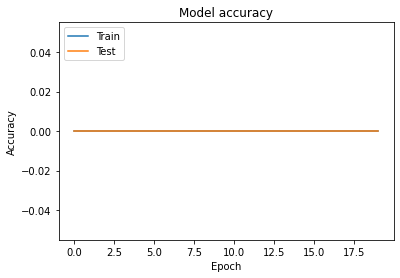

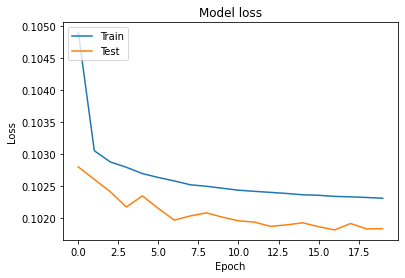

In [172]:
# Plot training accuracy & loss values
plt.plot(range(EPOCHS), history['train_acc'])
plt.plot(range(EPOCHS), history['test_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot test accuracy and loss values
plt.plot(range(EPOCHS), history['train_loss'])
plt.plot(range(EPOCHS), history['test_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Display generated digits

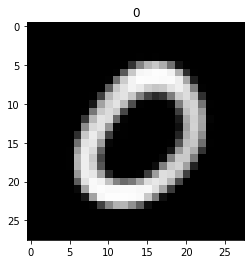

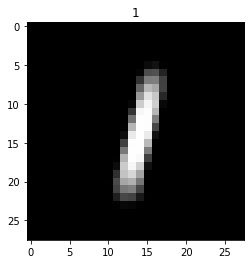

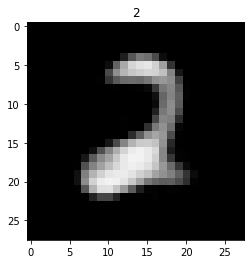

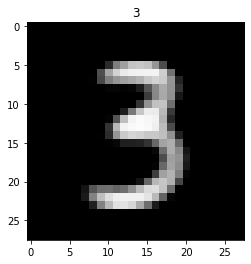

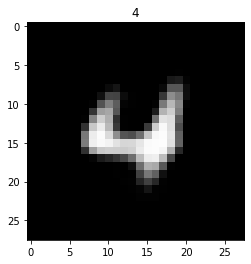

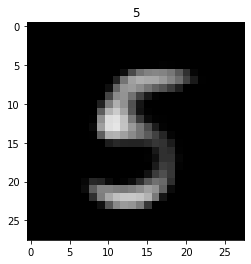

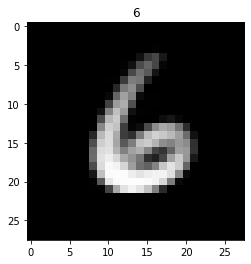

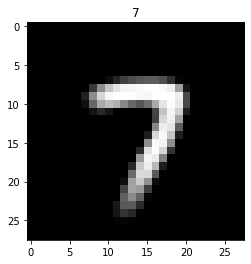

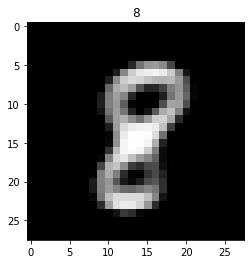

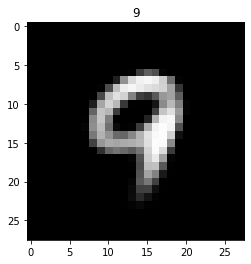

In [173]:
# create one hot vector for each digit 0-9
x = np.zeros([10, 10])
for i in range(len(x[0])):
  x[i][i] = 1

# use trained model to infer
infer = model(x) * 255.0 # reverse normaliztion
infer = np.reshape(infer, (infer.shape[0], 28, 28))

# print result images
for i in range(len(infer)):
  plt.imshow(infer[i], cmap='gray', vmin=0, vmax=255)
  plt.title(str(i))
  plt.show()

plt.show()